In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, root
import SpectralMethods as sm


In [25]:
# Initialize Magnet and System classes for simulation

class Magnet:
    def __init__(self, position, momentum):
        self.position = np.array(position)
        self.momentum = np.array(momentum)
        
    def potential(self, theta, mu0=1, l=1):
        # Calculate the potential energy of the pendulum at a given angle theta
        pendulum_direction = np.array([np.sin(theta), np.cos(theta)])
        pendulum_position = l * pendulum_direction
        pendulum_momentum = pendulum_direction
        
        # Calculate the magnetic field at the pendulum's position
        r = pendulum_position - self.position
        r_norm = np.linalg.norm(r)
        B = (mu0 / 4 * np.pi) * (3 * r * r.dot(self.momentum) - self.momentum) / (r_norm**5)
        
        # Calculate the potential energy from the magnetic field
        Um = -pendulum_momentum.dot(B)
        
        return Um
    
    def potential_derivative(self, theta, mu0=1, dtheta=1e-5, l=1):
        # Finite difference derivative of the potential energy
        val0 = self.potential(theta - dtheta, mu0=mu0, l=l)
        val1 = self.potential(theta + dtheta, mu0=mu0, l=l)
        
        return (val1 - val0) / (2 * dtheta)

class System:
    def __init__(self, ic=[0, 0], length=1, moment=1, t_max=100, dt=0.1, g=9.8, mu0=1.256e-6, damp=0.2):
        self.angle = ic[0]
        self.velocity = ic[1]
        self.length = length
        self.moment = moment
        self.t_max = t_max
        self.dt = dt
        self.g = g
        self.damp = damp
        self.mu0 = mu0
        
        self.magnets = []
        self.angle_list = []
        self.velocity_list = []
        self.critical_points = []
        
    def add_magnet(self, magnet):
        self.magnets.append(magnet)
        
    def rhs(self, state):
        # Calculate the next state from the right-hand side of the system of first order ODEs
        angle = state[0]
        velocity = state[1]
        
        dL = -self.g / self.length * np.sin(angle) - self.damp * velocity
        
        for magnet in self.magnets:
            dL += magnet.potential_derivative(state[0], mu0=self.mu0, l=self.length)
        
        # Return according to definition of the first order system
        return np.array([
            state[1], 
            dL
        ])
        
    def rk4_step(self, state):
        # Standard Runge-Kutta 4th order time-stepping scheme
        k1 = self.rhs(state)
        k2 = self.rhs(state + self.dt / 2 * k1)
        k3 = self.rhs(state + self.dt / 2 * k2)
        k4 = self.rhs(state + self.dt * k3)
        
        return state + self.dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        
    def solve(self, save=True):
        # Number of simulation time steps
        num_steps = int(self.t_max / self.dt)
        
        # Initialize solution trajectory
        state = np.array([self.angle, self.velocity])
        trajectory = [state]
        
        # Simulate the system using Runge-Kutta time-stepping
        for _ in range(num_steps - 1):
            trajectory.append(self.rk4_step(trajectory[-1]))
        
        trajectory = np.array(trajectory)
        
        # Save the results to the object
        self.angle_list = trajectory[:, 0]
        self.velocity_list = trajectory[:, 1]
        self.critical_points = self.get_critical_angles()
        
        # Save the results for animation purposes
        if save:
            np.save("angle_list.npy", self.angle_list)
            np.save("velocity_list.npy", self.velocity_list)
            magnets = np.array([np.concatenate([magnet.position, magnet.momentum]) for magnet in self.magnets])
            np.save("magnets.npy", magnets)
            np.save("critical_points.npy", self.critical_points)
    
    def plot_solution(self, ax=None, color=None):
        # Plot the angle trajectory as function of time
        if ax is None:
            fig, ax = plt.subplots()
            
        ax.set_title("Solution")
        ax.set_xlabel("Time")
        ax.set_ylabel("Angle")
        
        time_steps = np.linspace(0, self.t_max, len(self.angle_list))
        plt.plot(time_steps, self.angle_list, color=color)
    
    def plot_potential(self, ax=None, color=None, resolution=500):
        # Plot the potential energy of the system as a function of angle
        if ax is None:
            fig, ax = plt.subplots()
                
        # Calculate the total potential energy of the system 
        def total_potential(angle):
            potential = self.g / self.length * (1 - np.cos(angle))  # Gravitational potential, reference at (x,y) = (0,l)
            for magnet in self.magnets:
                potential -= magnet.potential(angle, mu0=self.mu0, l=self.length)
                
            return potential
        
        angles = np.linspace(-np.pi, np.pi, resolution, endpoint=False)
        
        potentials = [total_potential(angle) for angle in angles]
        plt.plot(angles, potentials, color=color)
        
        return potentials
    
    def plot_potential_derivative(self, ax=None, color=None, resolution=500):
        # Plot the derivative of the potential energy as a function of angle
        if ax is None:
            fig, ax = plt.subplots()
        
        # ax.set_xlabel("Angle")
        # ax.set_ylabel("Potential")
        
        angles = np.linspace(-np.pi, np.pi, resolution, endpoint=False)
        
        dpotentials = [self.rhs([angle, 0])[1] for angle in angles]
        plt.plot(angles, dpotentials, color=color)
        
        return dpotentials
    
    def get_critical_angles(self):
        critical_angles = []
        initial_angles = np.linspace(-np.pi, np.pi, 500, endpoint=False)
        
        tol = 1e-5
        for angle in initial_angles:
            # Find the roots of the derivate of potential - root works better than fsolve
            new_crit_angle = root(self.rhs, [angle, 0]).x[0] % (2 * np.pi)
            
            # Only add new critical point, if it is not already in the list _AND_ if it is sufficiently close to zero
            is_new = True
            for crit_angle in critical_angles:
                if np.abs(crit_angle - new_crit_angle) < tol or np.abs(crit_angle - (new_crit_angle - 2 * np.pi)) < tol:
                    is_new = False
                    break
                if np.abs(self.rhs([new_crit_angle, 0])[1]) > 1e-8:
                    is_new = False
                    break
            if is_new:
                critical_angles.append(new_crit_angle)
            
        return (np.array(critical_angles) + np.pi) % (2 * np.pi) - np.pi
    
    def check_stability(self, critical_angle, dtheta=1e-6):
        # Finite difference derivative for finding the second derivative
        val0 = self.rhs([critical_angle - dtheta, 0.0])[1]
        val1  = self.rhs([critical_angle + dtheta, 0.0])[1]
        
        return (val1 - val0) / (2 * dtheta)


def plot_bifurcation(magnet_pos=None, ax=None, color=None, strength_range = [-1, 1], resolution=100):
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.set_title("Bifurcation Diagram")
    ax.set_xlabel("Magnet strength")
    ax.set_ylabel("Angle")
    
    # Find critical angles for each magnet strength
    strengths = np.linspace(strength_range[0], strength_range[1], resolution)
    critical_angles = []
    for i, strength in enumerate(strengths):
        print(i, end=" ")  # Debugging
        
        # Initialize system, add magnet and find critical angles
        system = System()
        if magnet_pos is not None:
            magnet = Magnet(magnet_pos, [0, strength])
            system.add_magnet(magnet)
        
        # Append (strength, critical_angle) to list for bifurcation plot
        crit_temp = system.get_critical_angles()
        for crit_angle in crit_temp:
            critical_angles.append([strength, crit_angle])
    
    critical_angles = np.array(critical_angles)
    ax.plot(critical_angles[:, 0], critical_angles[:, 1], 'o', color=color)
    

[-3.14159265  0.        ]


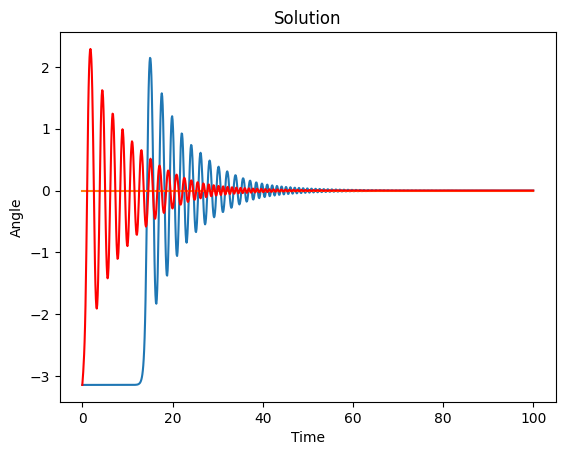

[1.2001538631644061e-15, 0.0]


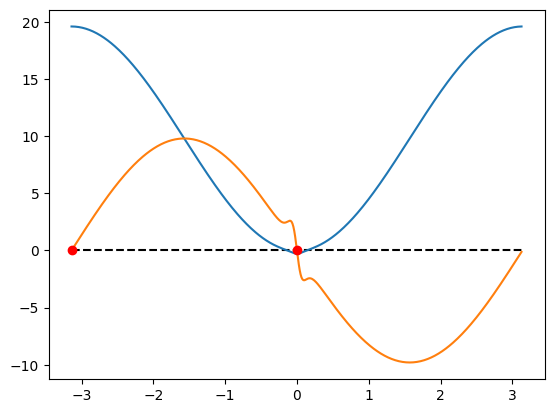

In [33]:
fig, ax = plt.subplots()

marcus = System(dt=0.1, t_max=100)
marcus.add_magnet(Magnet([0.0, 1.2], [0.0, 100]))
crit_points = marcus.get_critical_angles()
trajectory_values = []
print(crit_points)
for angle in crit_points:
# for angle in crit_points[::-1]:
    marcus.angle = angle
    marcus.velocity = 0
    marcus.solve()
    marcus.plot_solution(ax=ax)

marcus.angle = -np.pi * 0.999999999999999
marcus.velocity = 1
marcus.solve()
marcus.plot_solution(ax=ax, color="red")
plt.show()

fig, ax = plt.subplots()
ax.plot([-np.pi, np.pi], [0, 0], "k--")
p = marcus.plot_potential(ax=ax)
D = sm.fourier_diff_D(len(p))
marcus.plot_potential_derivative(ax=ax)
# ax.plot(np.linspace(-np.pi, np.pi, len(p)), -D.dot(p), "g")
ax.plot(crit_points, [0] * len(crit_points), "ro")

# print(marcus.rhs([1, 0]))
print([marcus.rhs([cp, 0])[1] for cp in crit_points])


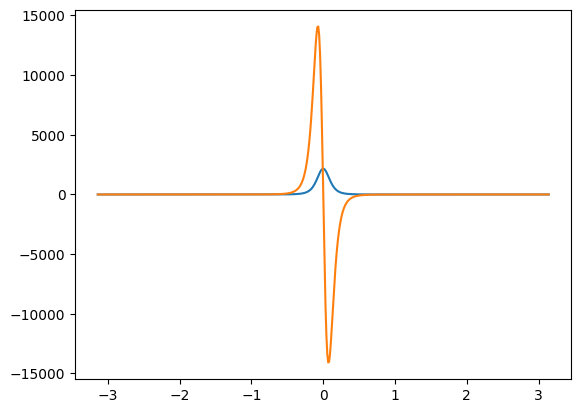

In [4]:
m = Magnet([0, 1.2], [0, 1])
thetas = np.linspace(-np.pi, np.pi, 500)
potentials = [m.potential(theta) for theta in thetas]
dpotentials = [m.potential_derivative(theta) for theta in thetas]
plt.plot(thetas, potentials)
plt.plot(thetas, dpotentials)
plt.show()

In [5]:
# def do_bifurcation_analysis():
#     """
#     We vary the y-component of the magnet's dipole moment from 0 to 2.0,
#     find equilibrium angles, and do a naive stability classification.
#     """
#     magnet_strengths = np.linspace(-0.25, 0.1, 30)
#     eq_angles_by_strength = []
#     stability_by_strength = []

#     for strength in magnet_strengths:
#         # pendulum = System(ic=[0.0, 0.0], damp=0.2, moment=1, dt=0.01, t_max=10)
#         pendulum = System()
        
#         my_magnet = Magnet([1, 1], [0.0, strength])
#         pendulum.add_magnet(my_magnet)
        
#         eqs = pendulum.get_critical_points()
        
#         eq_thetas = []
#         eq_stabs  = []
#         for eq_point in eqs:
#             eq_thetas.append(eq_point)
#             second_deriv = pendulum.check_stability(eq_point)
#             eq_stabs.append(second_deriv)
        
#         eq_angles_by_strength.append(eq_thetas)
#         stability_by_strength.append(eq_stabs)

#     return magnet_strengths, eq_angles_by_strength, stability_by_strength


# def plot_bifurcation(magnet_strengths, eq_angles_by_strength, stability_by_strength):
#     plt.figure(figsize=(8,5))
#     for i, mag_str in enumerate(magnet_strengths):
#         eqs = eq_angles_by_strength[i]
#         stabs = stability_by_strength[i]
#         for theta_eq, stab_val in zip(eqs, stabs):
#             color = 'blue' if stab_val < 0 else 'red'
#             plt.plot(mag_str, theta_eq, marker='o', color=color, alpha=0.7)

#     plt.title("Bifurcation Diagram: Equilibria vs. Magnet Dipole Strength")
#     plt.xlabel("Magnet Dipole Magnitude (y-component)")
#     plt.ylabel("Equilibrium Angle (rad)")
#     plt.grid(True)
#     plt.show()



# magnet_strengths, eq_angles, eq_stabilities = do_bifurcation_analysis()

# plot_bifurcation(magnet_strengths, eq_angles, eq_stabilities)